# Build Hybrid MgSiO3 Model using multiple datasets
* Combine MD simulations of Spera et al. (2011) and deKoker(2009) with experimental 1 bar measurements to develop best overall model
* Use high resolution model to Spera dataset as prior for thermal and gamma components
* Need to adjust parameters to account for altered V0 value (for both gamma and RT coef model)
* refit V0, K0, KP0, E0
* compare resulting ambient properties to experiment-based models of Ghiorso and Lange

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
import pickle

from collections import OrderedDict

import xmeos
from xmeos import models
from xmeos import datamod
CONSTS = models.CONSTS
import copy

In [2]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)
    
datasets = analysis['datasets']
param_tex_str = analysis['param_tex_str']
eos_electronic = analysis['eos_electronic']



In [3]:
def calc_thermal_data_derivs(data, remove_elec=False, eos_electronic=eos_electronic):
    tbl = data['table']
    dEdT = []
    dPdT = []
    Tavg = []
    Vavg = []

    # plt.figure()
    for Vlbl in np.round(data['V_labels'],2):
        mask = tbl['V_label']==Vlbl
        
        iE = tbl['E'][mask]
        iT = tbl['T'][mask]
        iP = tbl['P'][mask]
        iV = np.round(tbl['V'][mask],decimals=2)
        
        if remove_elec:
            iE -= eos_electronic.energy(iV, iT)
            iP -= eos_electronic.press(iV, iT)
    
        idEdT = np.diff(iE)/np.diff(iT)
        idPdT = np.diff(iP)/np.diff(iT)
    
        dEdT.extend(list(idEdT))
        dPdT.extend(list(idPdT))
    
        Tavg.extend(list(0.5*(np.array(iT[:-1]) + np.array(iT[1:]))))
        Vavg.extend(list(iV[:-1]))
    
        # plt.plot(tbl['T'][mask], tbl['E'][mask], 'ko-')

    Vavg = np.array(Vavg)
    Tavg = np.array(Tavg)
    dEdT = np.array(dEdT)
    dPdT = np.array(dPdT)
    
    thermal_deriv = OrderedDict()
    thermal_deriv['Vavg'] = Vavg
    thermal_deriv['Tavg'] = Tavg
    thermal_deriv['dEdT'] = dEdT
    thermal_deriv['dPdT'] = dPdT
    
    return thermal_deriv

def calc_heat_capacity(data, remove_elec=False, eos_electronic=eos_electronic):
    tbl = data['table']
    Cv = []
    T = []
    V = []

    # plt.figure()
    for Vlbl in np.round(data['V_labels'],2):
        mask = tbl['V_label']==Vlbl
        
        iE = tbl['E'][mask]
        iT = tbl['T'][mask]
        iV = np.round(tbl['V'][mask],decimals=2)
        
        if remove_elec:
            iE -= eos_electronic.energy(iV, iT)
    
        iCv = np.diff(iE)/np.diff(iT)/CONSTS['kboltz']
    
        Cv.extend(list(iCv))
    
        T.extend(list(0.5*(np.array(iT[:-1]) + np.array(iT[1:]))))
        V.extend(list(iV[:-1]))
    
        # plt.plot(tbl['T'][mask], tbl['E'][mask], 'ko-')

    V = np.array(V)
    T = np.array(T)
    Cv = np.array(Cv)
    
    heat_capacity_data = pd.DataFrame()
    heat_capacity_data['V'] = V
    heat_capacity_data['T'] = T
    heat_capacity_data['Cv'] = Cv
    
    return heat_capacity_data

def filter_compress_data(data, T0=3000, remove_elec=False, eos_electronic=eos_electronic):
    tbl = data['table'].copy()
    mask_T0 = tbl['T']==T0
    
    if remove_elec:
        # tbl['E'] -= eos_electronic.energy(tbl['V'], tbl['T'])
        tbl['P'] -= eos_electronic.press(tbl['V'], tbl['T'])

        
    tbl_T0 = tbl.loc[mask_T0]
    tbl_T0.reset_index(inplace=True, drop=True)
    
    compress_T0_data = datamod.load_data(
        title='T0_compress_dK09', datasource='3000K isotherm, deKoker2009',
        V=tbl_T0['V'], T=tbl_T0['T'], P=tbl_T0['P'], mass_avg=data_dK09['mass_avg'])

    # compress_T0_data = pd.DataFrame()
    # compress_T0_data['V'] = 
    # compress_T0_data['P'] = tbl.loc[mask_T0, 'P']
    # compress_T0_data['E'] = tbl.loc[mask_T0, 'E']
    # compress_T0_data.reset_index(inplace=True, drop=True)

    tbl_therm = tbl.loc[~mask_T0]
    tbl_therm.reset_index(inplace=True, drop=True)
    
    thermal_compress_data = datamod.load_data(
        title='thermal_compress_dK09', datasource='thermal pressure, deKoker2009',
        V=tbl_therm['V'], T=tbl_therm['T'], P=tbl_therm['P'], 
        mass_avg=data_dK09['mass_avg']
    )
    
    # thermal_compress_data = pd.DataFrame()
    # thermal_compress_data['V'] = tbl.loc[~mask_T0, 'V']
    # thermal_compress_data['T'] = tbl.loc[~mask_T0, 'T']
    # thermal_compress_data['P'] = tbl.loc[~mask_T0, 'P']
    # thermal_compress_data['Ptherm'] = 
    # thermal_compress_data.reset_index(inplace=True, drop=True)
    
    return compress_T0_data, thermal_compress_data



In [4]:
data_dK09 = datasets['deKoker2009']
data_S11 = datasets['Spera2011']

eos_mod_dK09 = analysis['datamodel_dK09']['eos_mod']
# View data tables
# tbl = data['table']
# tbl

In [5]:
print(analysis['props_Lange'])
dPdT_ref = 8.5e-5*19.35*1e3
V_ref = 12.8
T_ref = 1673

{'P': 0, 'T': 1673, 'V': 12.803751383249672, 'dVdT': 0.001635, 'alpha': 8.481830207765933e-05, 'betaT': 0.05167955671413378, 'KT': 19.3500111762087}


In [6]:
compress_T0_data, thermal_compress_data = filter_compress_data(data_dK09, remove_elec=True)
display(compress_T0_data)
display(thermal_compress_data)

{'datasource': '3000K isotherm, deKoker2009',
 'exp_constraint': None,
 'mass_avg': 20.080000000000002,
 'table':            V     T           P  trust  Verr
 0  15.502791  3000   -0.628020   True     0
 1  14.210892  3000   -0.045205   True     0
 2  12.918993  3000    2.573635   True     0
 3  11.627094  3000    5.029234   True     0
 4  10.335194  3000   13.265108   True     0
 5   9.043295  3000   26.953321   True     0
 6   7.751396  3000   53.257329   True     0
 7   6.459496  3000  126.058632   True     0,
 'title': 'T0_compress_dK09'}

{'datasource': 'thermal pressure, deKoker2009',
 'exp_constraint': None,
 'mass_avg': 20.080000000000002,
 'table':             V     T           P  trust  Verr
 0   14.210892  2000   -1.058632   True     0
 1   12.918993  2000    1.302932   True     0
 2   11.627094  2000    3.583062   True     0
 3   10.335194  2000   10.097720   True     0
 4   15.502791  4000    0.880909   True     0
 5   14.210892  4000    1.316587   True     0
 6   12.918993  4000    3.791755   True     0
 7   11.627094  4000    7.085465   True     0
 8   10.335194  4000   16.898579   True     0
 9    9.043295  4000   31.032725   True     0
 10   7.751396  4000   62.761084   True     0
 11   6.459496  4000  136.755076   True     0
 12   5.167597  4000  318.433291   True     0
 13  15.502791  6000    2.235095   True     0
 14  14.210892  6000    3.094303   True     0
 15  12.918993  6000    7.220044   True     0
 16  11.627094  6000   13.311940   True     0
 17  10.335194  6000   23.002197   True     0
 18   9.043

In [7]:
kind_compress='Vinet'
eos_compress = models.CompressEos(kind=kind_compress, path_const='T')
V0, K0, KP0 = eos_mod_dK09.get_param_values(param_names=['V0','K0','KP0'])

T0 = 3000
eos_compress.set_param_values([V0,K0,KP0],param_names=['V0','K0','KP0'])

In [8]:
Vmod = np.linspace(6,16,101)

print(V0,K0,KP0)
Pmod0 = eos_compress.press(Vmod, T0)

14.74131057987277 9.774395005348184 7.416597855079822


In [9]:
datamodel_T0 = datamod.init_datamodel(compress_T0_data, eos_compress)


fit_calcs = ['compress']
# fix_params = ['S0','Cvlimfac','mexp']
# datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])
datamod.select_fit_params(datamodel_T0, fit_calcs)

In [10]:
datamod.fit(datamodel_T0, apply_bulk_mod_wt=True)
Pmod_fit = datamodel_T0['eos_mod'].press(Vmod, T0)

In [11]:
datamodel_T0['posterior']

OrderedDict([('param_names', ['V0', 'K0', 'KP0']),
             ('param_val', array([14.43766648, 11.80155992,  7.15911387])),
             ('param_err', array([0.0709151 , 0.61666816, 0.15914957])),
             ('param_tbl',   name      value     error
              0   V0  14.437666  0.070915
              1   K0  11.801560  0.616668
              2  KP0   7.159114  0.159150),
             ('corr', array([[ 1.        , -0.24211913, -0.16230873],
                     [-0.24211913,  1.        , -0.88914477],
                     [-0.16230873, -0.88914477,  1.        ]])),
             ('fit_err',
              {'E': 0.0, 'P': 1.4655074321498458, 'V': 0.18470297890527815}),
             ('R2fit',
              {'E': 1.0, 'P': 0.9989540309866627, 'V': 0.9968496638485228})])

In [12]:
param_draw, param_names = datamod.draw_from_posterior(datamodel_T0, Ndraw=10)


In [13]:
print(param_names)
print(param_draw)

['V0', 'K0', 'KP0']
[[14.39681035 11.72827276  7.1716079 ]
 [14.4735935  11.55890793  7.17120777]
 [14.33486103 12.07032017  7.17160431]
 [14.30729341 11.81232761  7.2624709 ]
 [14.47180642 12.67827269  6.93112834]
 [14.52087542 11.52036679  7.15006923]
 [14.4782628  11.67565971  7.14595928]
 [14.49651549 11.94125421  7.07241319]
 [14.35809524 12.75787598  6.99377621]
 [14.41765662 11.31463755  7.34615337]]


In [23]:
Pbounds, Pdraw = datamod.posterior_prediction(Vmod, T0, 'press', datamodel_T0, 
                                              Ndraw=1000, percentile=[2.5,97.5])

In [22]:
50-95/2

2.5

<IPython.core.display.Javascript object>


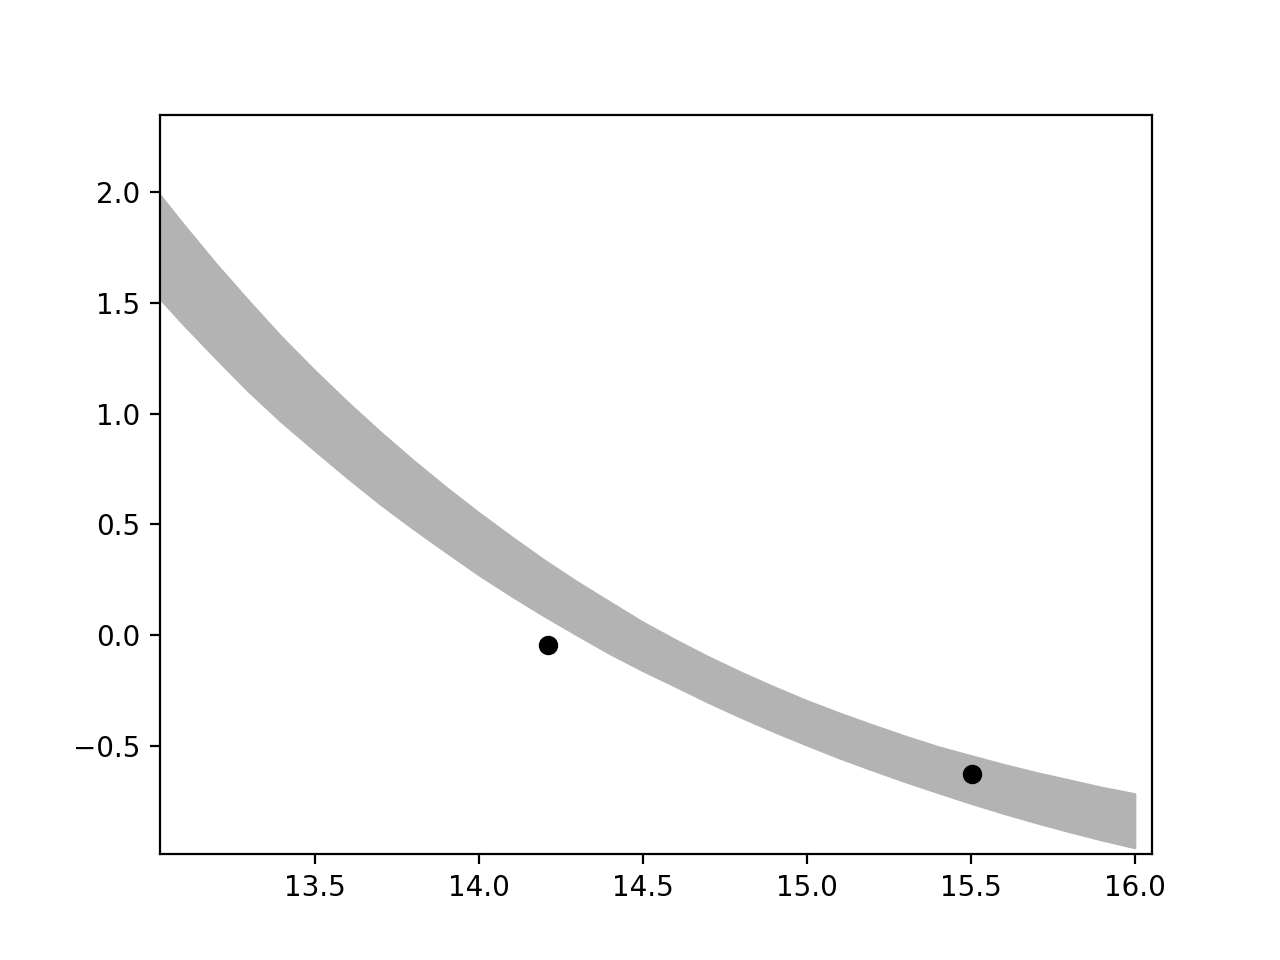

In [24]:

plt.figure()
plt.fill_between(Vmod, Pbounds[0], Pbounds[-1], color=[.7,.7,.7])
# plt.plot(Vmod, Pmod_fit, 'r-')
plt.plot(compress_T0_data['table']['V'], compress_T0_data['table']['P'], 'ko')


In [17]:
import scipy as sp
sp.random.multivariate_normal?

In [6]:
eos_electronic

ElectronicEos(kind='CvPowLaw', natom=1, apply_correction=True, model_state={'param_names': ['V0', 'CvelFac0', 'CvelFacExp', 'Tel0', 'TelExp'], 'param_values': [12.949250728485206, 0.000227133195932778, 0.6777360436990527, 2466.5988252168886, -0.45780164119556427]}, )

In [8]:
analysis['eos_mod']

RTPressEos(kind_compress='Vinet', compress_path_const='T', kind_gamma='GammaFiniteStrain', kind_electronic='CvPowLaw', apply_electronic=False, kind_RTpoly='V', RTpoly_order=4, natom=1, molar_mass=20.080000000000002, model_state={'param_names': ['V0', 'K0', 'KP0', 'gamma0', 'gammap0', 'mexp', 'Cvlimfac', 'CvelFac0', 'CvelFacExp', 'Tel0', 'TelExp', 'S0', 'E0', '_bcoef_0', '_bcoef_1', '_bcoef_2', '_bcoef_3', '_bcoef_4'], 'param_values': [12.949250728485206, 13.20006603991761, 8.238368225973854, 0.18994349597637739, -1.9402423309313312, 0.6, 1.0, 0.0003, 0.6, 3000.0, -0.3, 0.0, -20.595341083955592, 0.982133189959226, 0.6149895513624145, 1.3104950837064218, -3.040061729924666, -4.102279052001586]}, )

In [9]:
analysis['datamodel_dK09']['eos_mod']

RTPressEos(kind_compress='Vinet', compress_path_const='T', kind_gamma='GammaFiniteStrain', kind_electronic='CvPowLaw', apply_electronic=True, kind_RTpoly='V', RTpoly_order=4, natom=1, molar_mass=20.080000000000002, model_state={'param_names': ['V0', 'K0', 'KP0', 'gamma0', 'gammap0', 'mexp', 'Cvlimfac', 'CvelFac0', 'CvelFacExp', 'Tel0', 'TelExp', 'S0', 'E0', '_bcoef_0', '_bcoef_1', '_bcoef_2', '_bcoef_3', '_bcoef_4'], 'param_values': [14.74131057987277, 9.774395005348184, 7.416597855079822, 0.2821630474473029, -1.3486973068288652, 0.6, 1.0, 0.0003, 0.6, 3000.0, -0.3, 0.0, -6.849941170742585, 1.117651968385785, -0.05441257314157945, 2.0676923919998025, 12.944324891895999, 15.515112609363015]}, )

In [11]:
data_dK09['table'].head()

,V,T,P,E,trust,Verr,T_label,V_label
0,14.210892,2000,-1.058632,-7.228171,True,0,2000.0,14.21
1,12.918993,2000,1.302932,-7.240976,True,0,2000.0,12.92
2,11.627094,2000,3.583062,-7.232767,True,0,2000.0,11.63
3,10.335194,2000,10.097720,-7.256082,True,0,2000.0,10.34
4,15.502791,3000,-0.599026,-6.850816,True,0,3000.0,15.50


In [12]:
#plt.figure()
#plt.scatter(data_S11['table']['T'], data_S11['table']['E'], c=data_S11['table']['V'])



In [18]:
heat_capacity_data = calc_heat_capacity(data_dK09, remove_elec=True)
heat_capacity_data.head()

,V,T,Cv
0,5.17,5000.0,2.836716
1,5.17,7000.0,4.193554
2,6.46,3500.0,3.453342
3,6.46,5000.0,3.598485
4,7.75,3500.0,3.747477


In [19]:
thermal_deriv_S11 = calc_thermal_data_derivs(data_S11)
thermal_deriv_dK09 = calc_thermal_data_derivs(data_dK09, remove_elec=True)

<IPython.core.display.Javascript object>


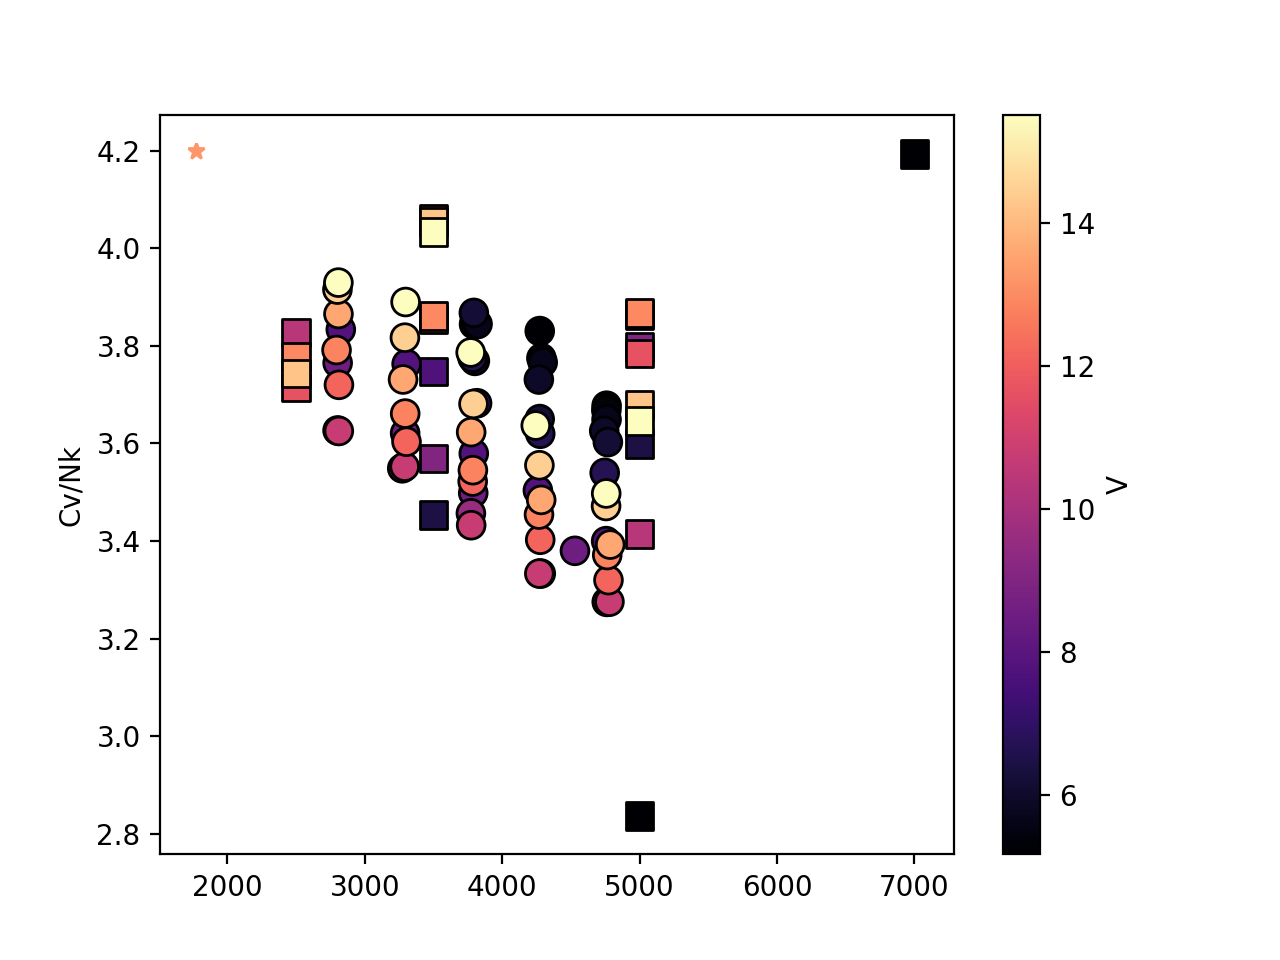

<IPython.core.display.Javascript object>


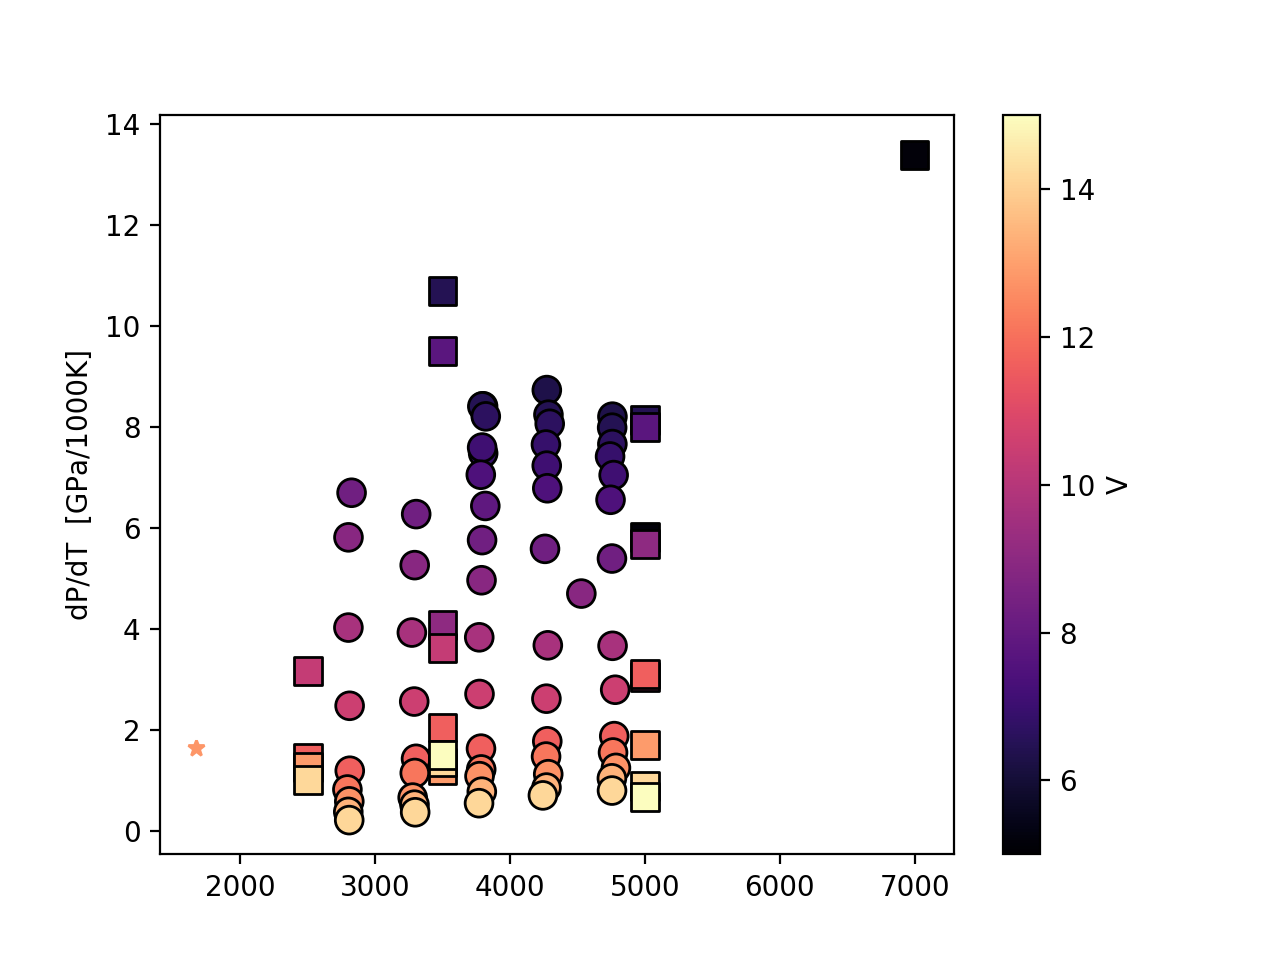

In [23]:
Vbnds = [5,15]

cmap = plt.get_cmap('gist_earth')
cmap = plt.get_cmap('magma')
# cmap = plt.get_cmap('viridis')
col_ref = (V_ref-Vbnds[0])/(Vbnds[1]-Vbnds[0])

plt.figure()
plt.scatter(thermal_deriv_S11['Tavg'],thermal_deriv_S11['dEdT']/CONSTS['kboltz'], 
            c=thermal_deriv_S11['Vavg'], cmap=cmap, edgecolor='k', s=100)
plt.scatter(thermal_deriv_dK09['Tavg'],thermal_deriv_dK09['dEdT']/CONSTS['kboltz'],
            c=thermal_deriv_dK09['Vavg'], marker='s', cmap=cmap, edgecolor='k', s=100)
plt.plot(1773,4.2,'*', color=cmap(col_ref))
plt.ylabel('Cv/Nk')
plt.colorbar(label='V')

plt.figure()
plt.scatter(thermal_deriv_S11['Tavg'],thermal_deriv_S11['dPdT']*1e3, 
            c=thermal_deriv_S11['Vavg'], cmap=cmap, edgecolor='k', s=100,
            vmin=Vbnds[0],vmax=Vbnds[1])

plt.scatter(thermal_deriv_dK09['Tavg'],thermal_deriv_dK09['dPdT']*1e3, 
            c=thermal_deriv_dK09['Vavg'], marker='s', cmap=cmap, edgecolor='k', s=100,
           vmin=Vbnds[0],vmax=Vbnds[1])


plt.plot(T_ref, dPdT_ref,'*', color=cmap(col_ref))
plt.ylabel('dP/dT  [GPa/1000K]')
plt.colorbar(label='V')

<IPython.core.display.Javascript object>


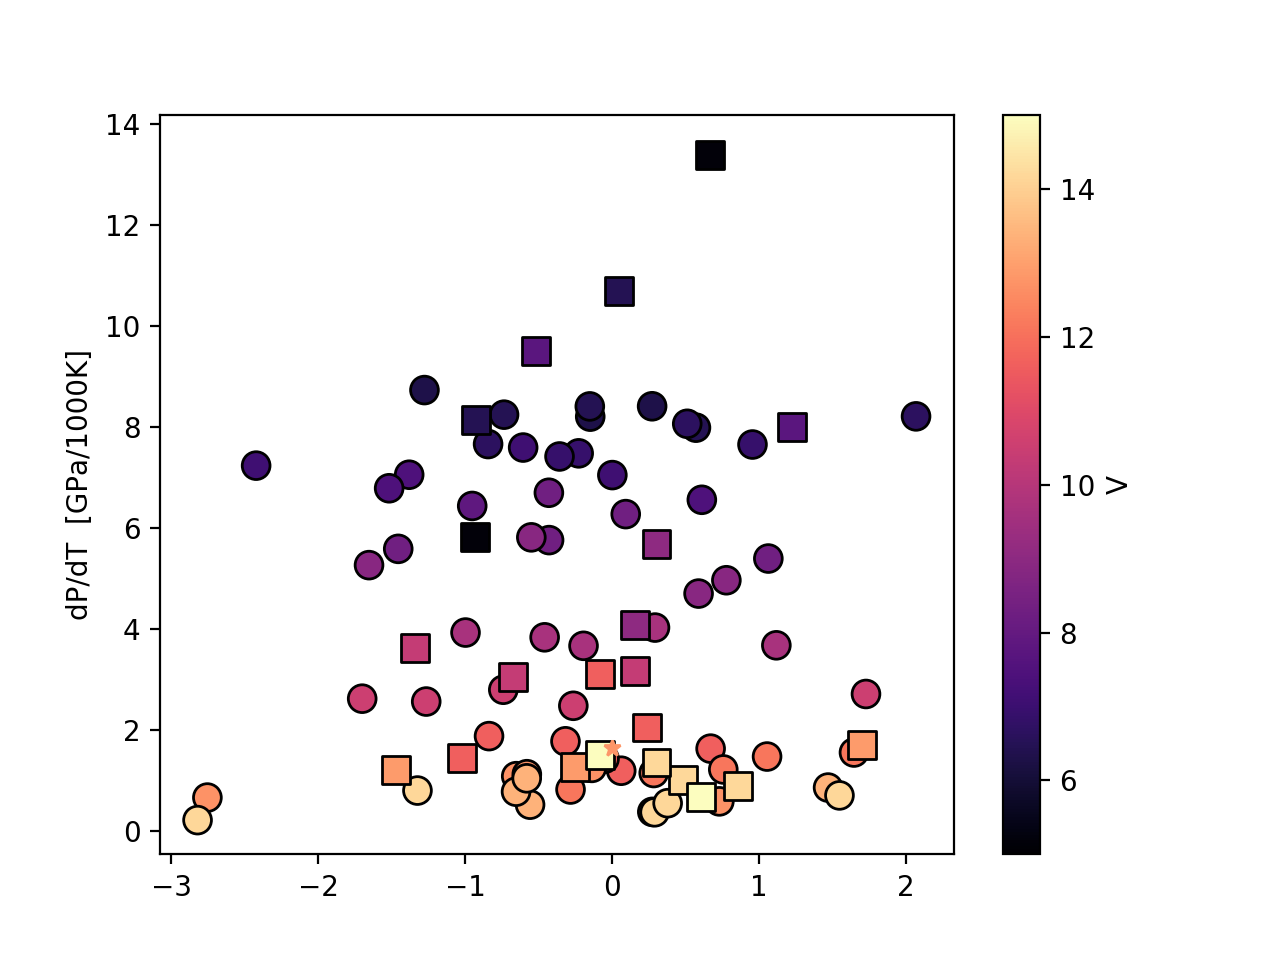

In [31]:
plt.figure()
plt.scatter(np.random.randn(len(thermal_deriv_S11['dPdT'])),thermal_deriv_S11['dPdT']*1e3, 
            c=thermal_deriv_S11['Vavg'], cmap=cmap, edgecolor='k', s=100,
            vmin=Vbnds[0],vmax=Vbnds[1])

plt.scatter(np.random.randn(len(thermal_deriv_dK09['dPdT'])),thermal_deriv_dK09['dPdT']*1e3, 
            c=thermal_deriv_dK09['Vavg'], marker='s', cmap=cmap, edgecolor='k', s=100,
           vmin=Vbnds[0],vmax=Vbnds[1])


plt.plot(dPdT_ref,'*', color=cmap(col_ref))
plt.ylabel('dP/dT  [GPa/1000K]')
plt.colorbar(label='V')

<IPython.core.display.Javascript object>


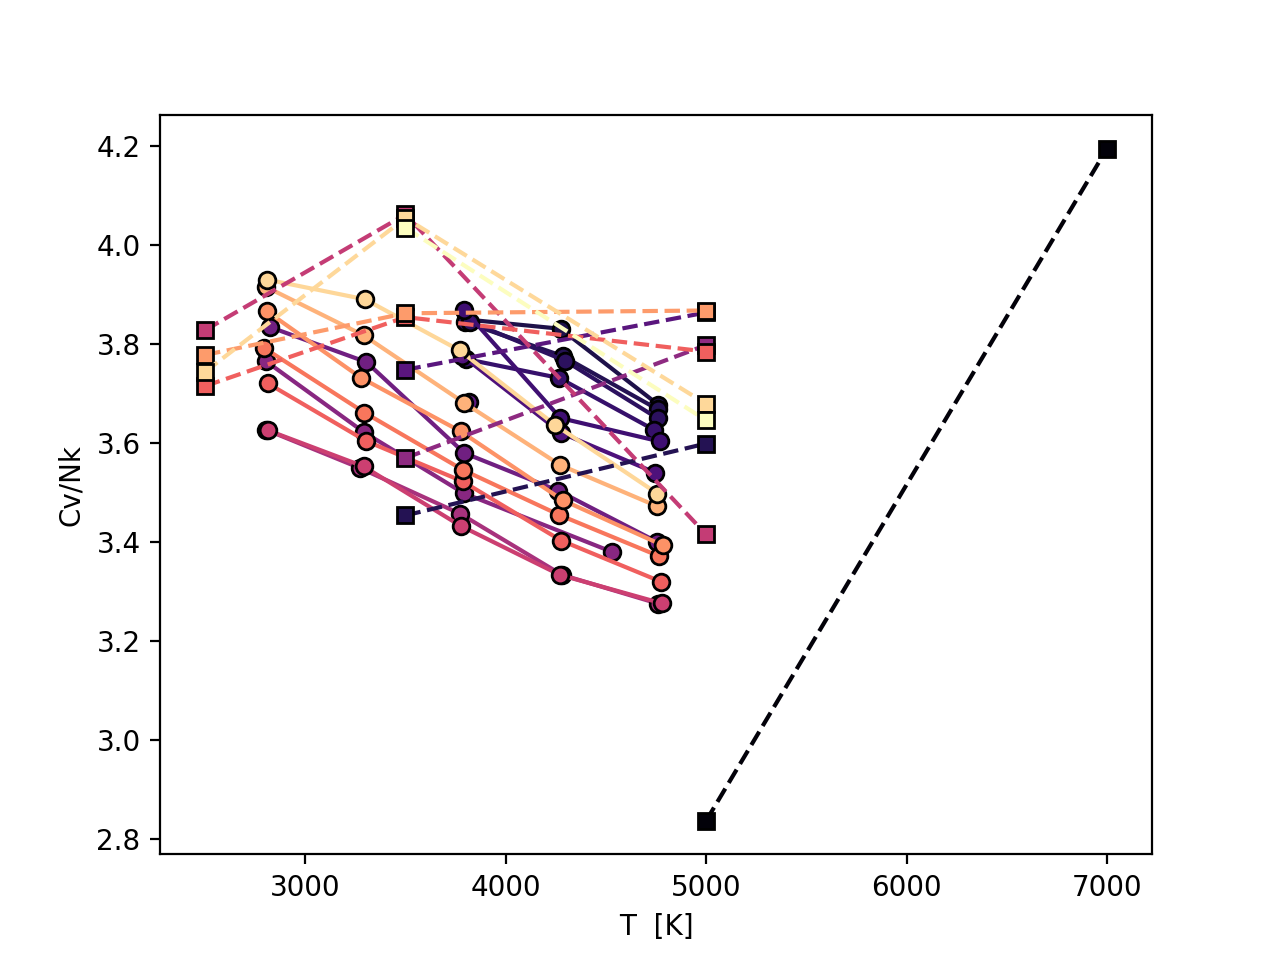

In [151]:

plt.figure()
Vavg = np.unique(thermal_deriv_S11['Vavg'])
for iV in Vavg:
    icol = (iV-Vbnds[0])/(Vbnds[1]-Vbnds[0])
    #icol = (iV-Vavg[0])/(Vavg[-1]-Vavg[0])
    mask = thermal_deriv_S11['Vavg']==iV
    plt.plot(thermal_deriv_S11['Tavg'][mask],thermal_deriv_S11['dEdT'][mask]/CONSTS['kboltz'], 
            'o-', markeredgecolor='k',color = cmap(icol))

Vavg = np.unique(thermal_deriv_dK09['Vavg'])
for iV in Vavg:
    icol = (iV-Vbnds[0])/(Vbnds[1]-Vbnds[0])
    #icol = (iV-Vavg[0])/(Vavg[-1]-Vavg[0])
    mask = thermal_deriv_dK09['Vavg']==iV
    plt.plot(thermal_deriv_dK09['Tavg'][mask],thermal_deriv_dK09['dEdT'][mask]/CONSTS['kboltz'], 
            's--', markeredgecolor='k',color = cmap(icol))
    
plt.ylabel('Cv/Nk')
plt.xlabel('T  [K]')
#plt.colorbar(label='V')

<IPython.core.display.Javascript object>


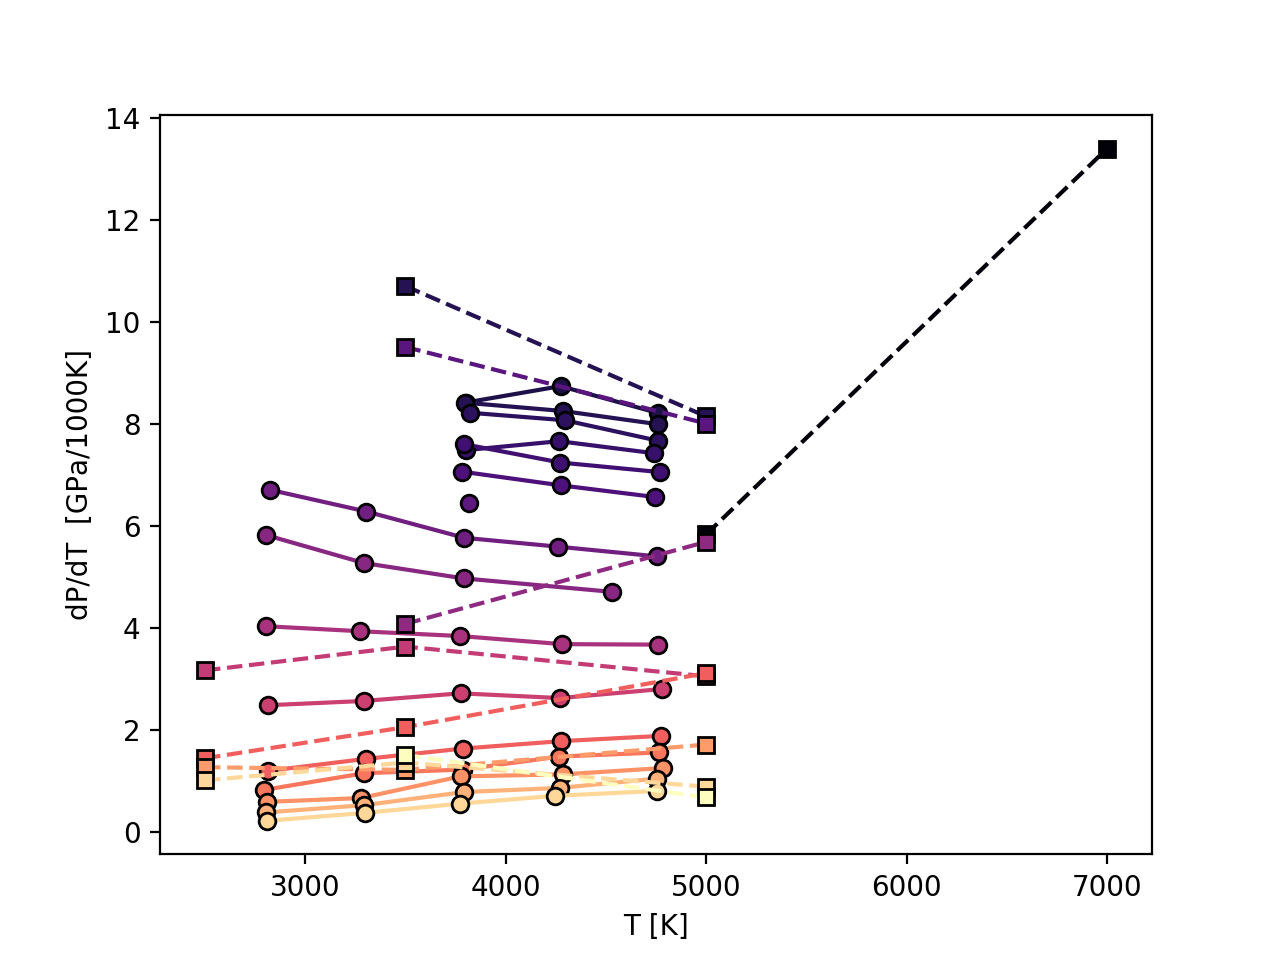

In [152]:
plt.figure()
Vavg = np.unique(thermal_deriv_S11['Vavg'])
for iV in Vavg:
    # icol = (iV-Vavg[0])/(Vavg[-1]-Vavg[0])
    icol = (iV-Vbnds[0])/(Vbnds[1]-Vbnds[0])
    mask = thermal_deriv_S11['Vavg']==iV
    plt.plot(thermal_deriv_S11['Tavg'][mask],thermal_deriv_S11['dPdT'][mask]*1e3, 
            'o-', markeredgecolor='k',color = cmap(icol))

Vavg = np.unique(thermal_deriv_dK09['Vavg'])
for iV in Vavg:
    icol = (iV-Vbnds[0])/(Vbnds[1]-Vbnds[0])
    #icol = (iV-Vavg[0])/(Vavg[-1]-Vavg[0])
    mask = thermal_deriv_dK09['Vavg']==iV
    plt.plot(thermal_deriv_dK09['Tavg'][mask],thermal_deriv_dK09['dPdT'][mask]*1e3, 
            's--', markeredgecolor='k',color = cmap(icol))
    
plt.ylabel('dP/dT  [GPa/1000K]')
plt.xlabel('T [K]')
#plt.colorbar(label='V')

In [182]:
tbl_dK09 = data_dK09['table']
mask_T3K = tbl_dK09['T']==3000

compress_T0_data = pd.DataFrame()
compress_T0_data['V'] = tbl_dK09.loc[mask_T3K, 'V']
compress_T0_data['P'] = tbl_dK09.loc[mask_T3K, 'P']

compress_T0_data.reset_index(inplace=True, drop=True)

thermal_compress_data = tbl_dK09.loc[~mask_T3K]
thermal_compress_data.reset_index(inplace=True, drop=True)
thermal_compress_data



,V,T,P,E,trust,Verr,T_label,V_label
0,14.210892,2000,-1.058632,-7.228171,True,0,2000.0,14.21
1,12.918993,2000,1.302932,-7.240976,True,0,2000.0,12.92
2,11.627094,2000,3.583062,-7.232767,True,0,2000.0,11.63
3,10.335194,2000,10.097720,-7.256082,True,0,2000.0,10.34
4,15.502791,4000,1.051204,-6.476039,True,0,4000.0,15.50
5,14.210892,4000,1.472626,-6.528378,True,0,4000.0,14.21
6,12.918993,4000,3.931708,-6.559818,True,0,4000.0,12.92
7,11.627094,4000,7.207228,-6.562529,True,0,4000.0,11.63
8,10.335194,4000,16.999778,-6.562849,True,0,4000.0,10.34
9,9.043295,4000,31.110825,-6.542476,True,0,4000.0,9.04


## Visualize FPMD data of deKoker et al. (2009)

In [4]:
datamodel_S11 = analysis['datamodel']
eos_mod = copy.deepcopy(datamodel_S11['eos_mod'])
datamodel = datamod.init_datamodel(data, eos_mod)

eos_mod.apply_electronic=True
# Set colorbar temperature properties
#cmap = plt.get_cmap('coolwarm',len(data['T_labels']))
cmap = plt.get_cmap('coolwarm')

delT = np.diff(data['T_labels'])[0]


dE0 = 13.75
E0 = eos_mod.get_params()['E0'] + dE0
eos_mod.set_param_values(E0,param_names='E0')

V0 = eos_mod.get_params()['V0']

eos_electronic.set_param_values(param_names=['V0'], param_values=V0)



Tlbl = data['T_labels']
# cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]

Vmod = V0*np.linspace(.35,1.2,1001)

In [5]:
P_electron = eos_electronic.press(tbl['V'],tbl['T'])
E_electron = eos_electronic.energy(tbl['V'],tbl['T'])

tbl['P'] -= P_electron
tbl['E'] -= E_electron

<IPython.core.display.Javascript object>


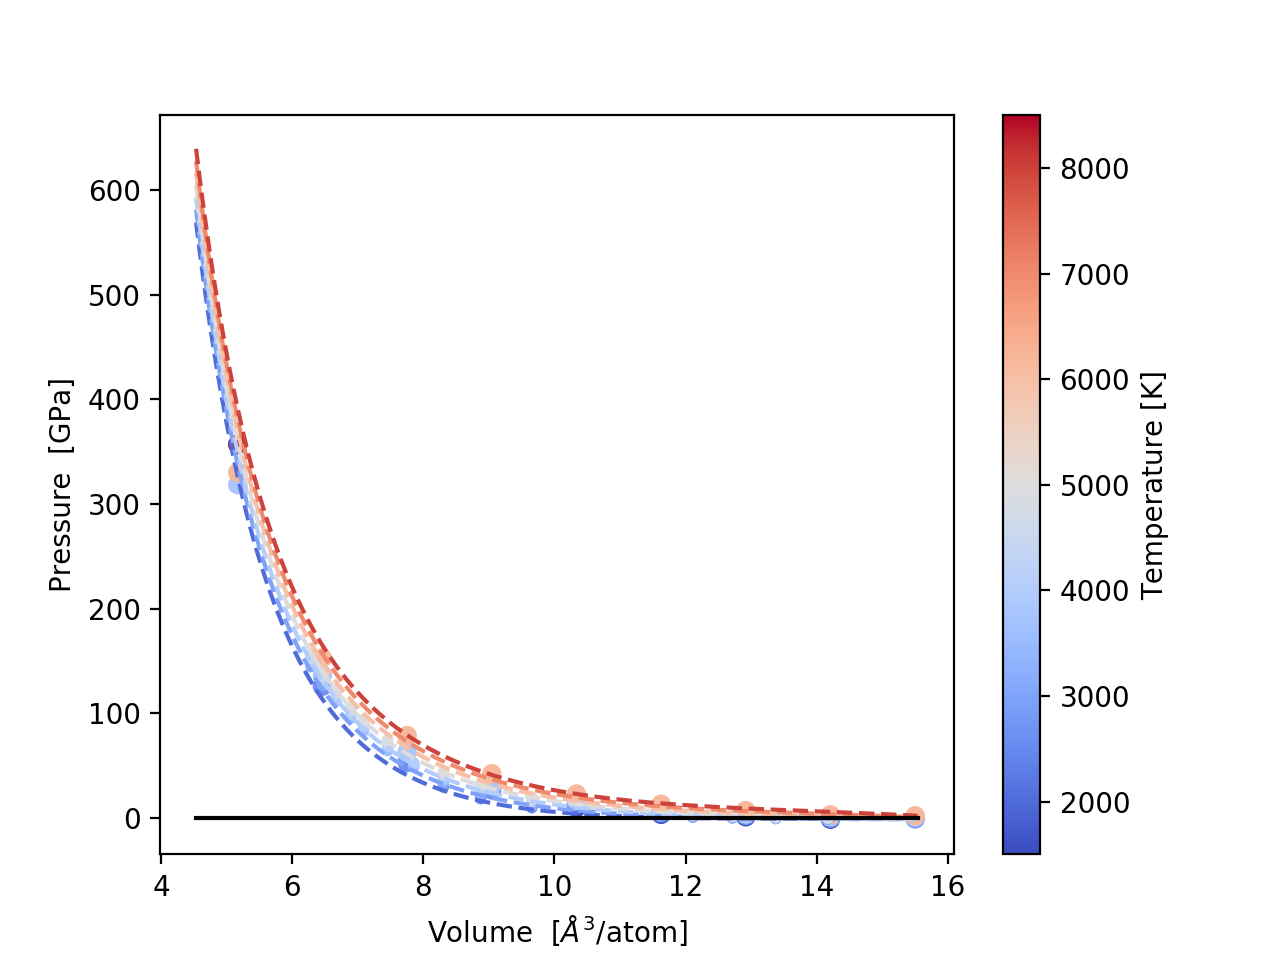

In [6]:

tbl_S11 = data_S11['table']

plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)
plt.scatter(tbl_S11['V'],tbl_S11['P'],c=tbl_S11['T'], s=10, cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

# plt.ylim(-2,15);
plt.plot(Vmod,0*Vmod,'k-')


<IPython.core.display.Javascript object>


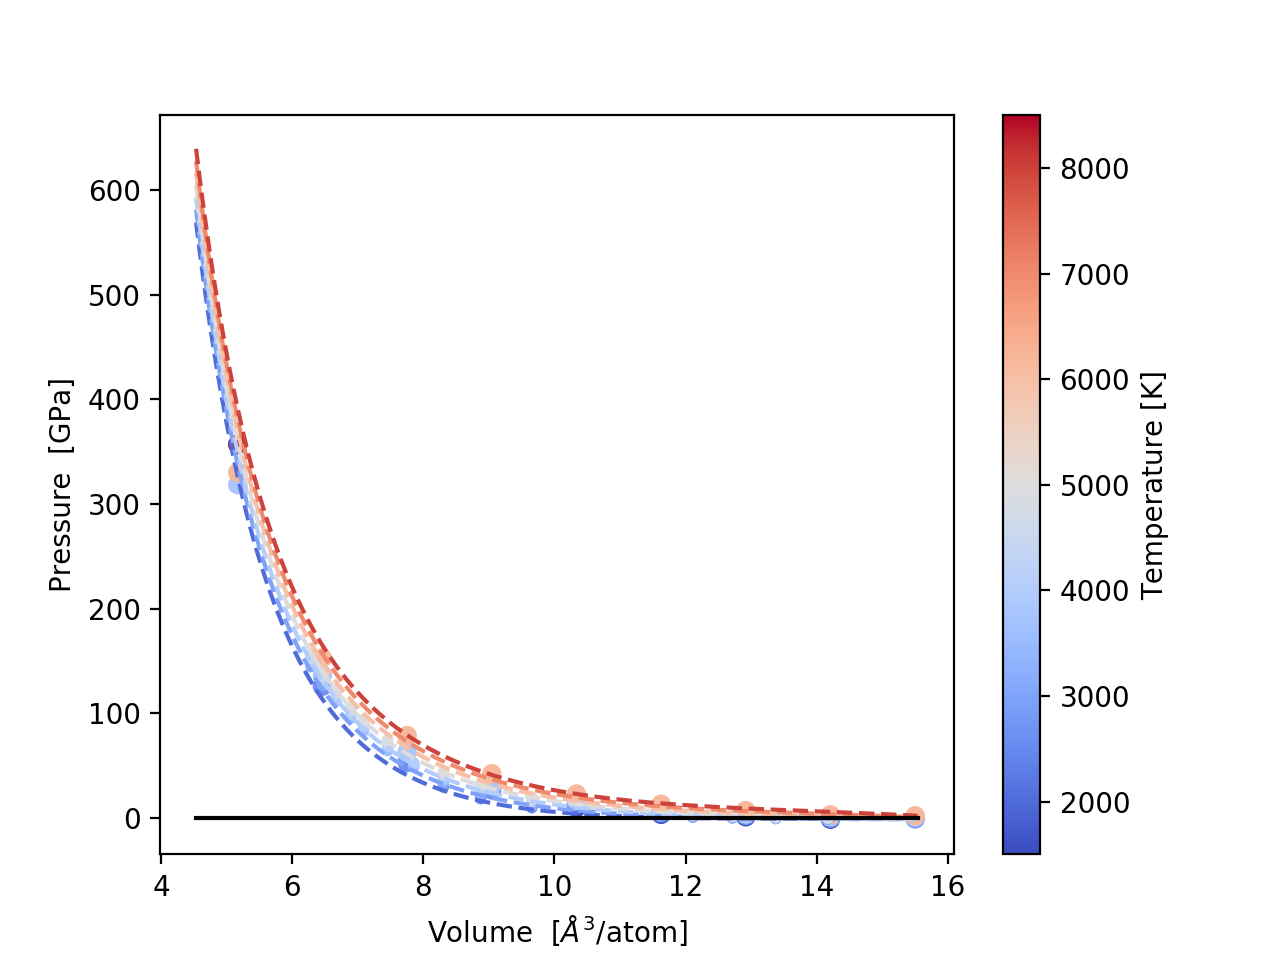

In [7]:
tbl_S11 = data_S11['table']

plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)
plt.scatter(tbl_S11['V'],tbl_S11['P'],c=tbl_S11['T'], s=10, cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

# plt.ylim(-2,15);
plt.plot(Vmod,0*Vmod,'k-')


In [8]:
eos_mod.apply_electronic=True

<IPython.core.display.Javascript object>


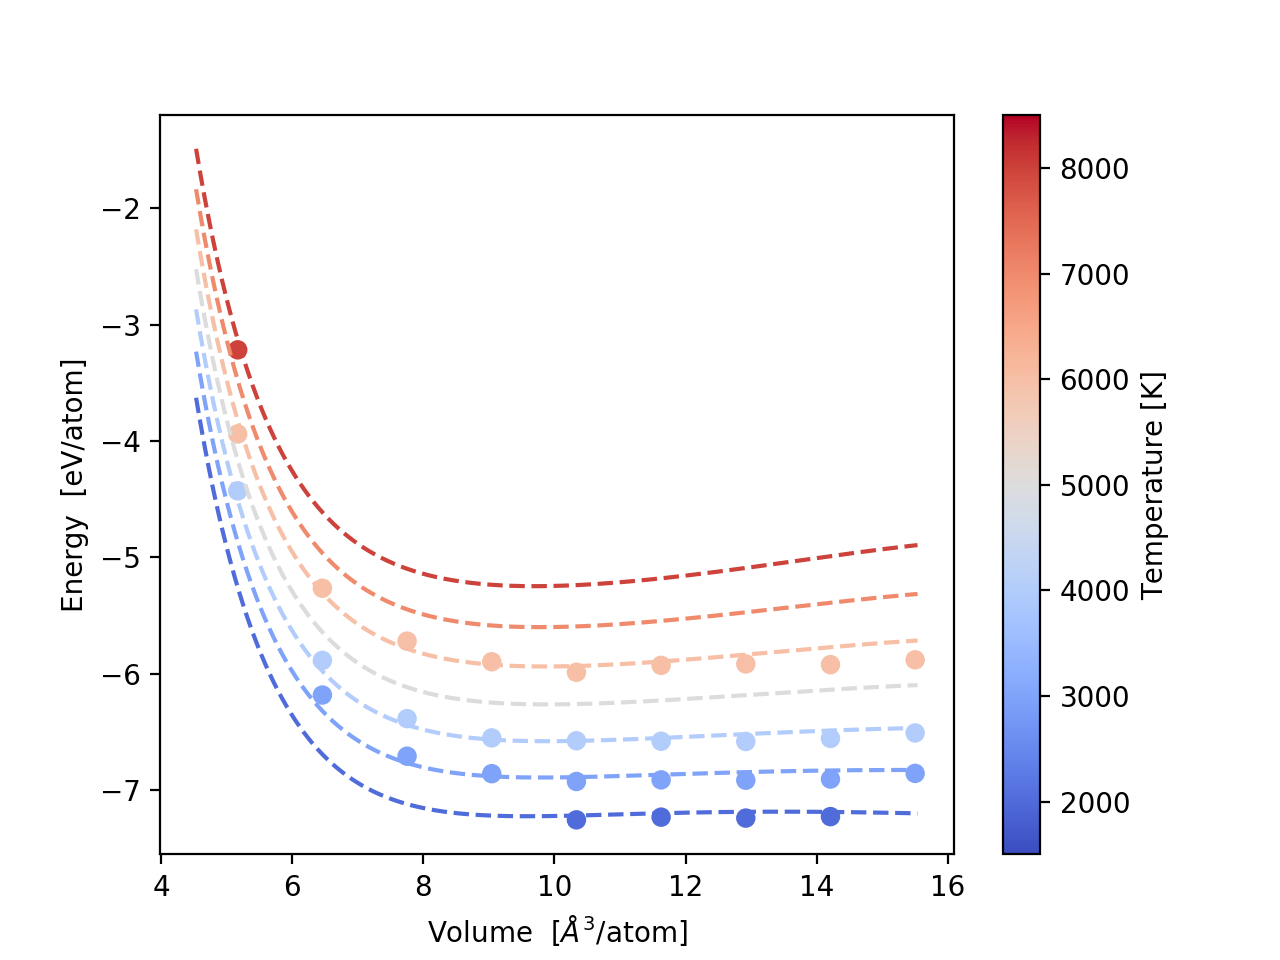

In [9]:


plt.figure()
plt.scatter(tbl['V'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.internal_energy(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

<IPython.core.display.Javascript object>


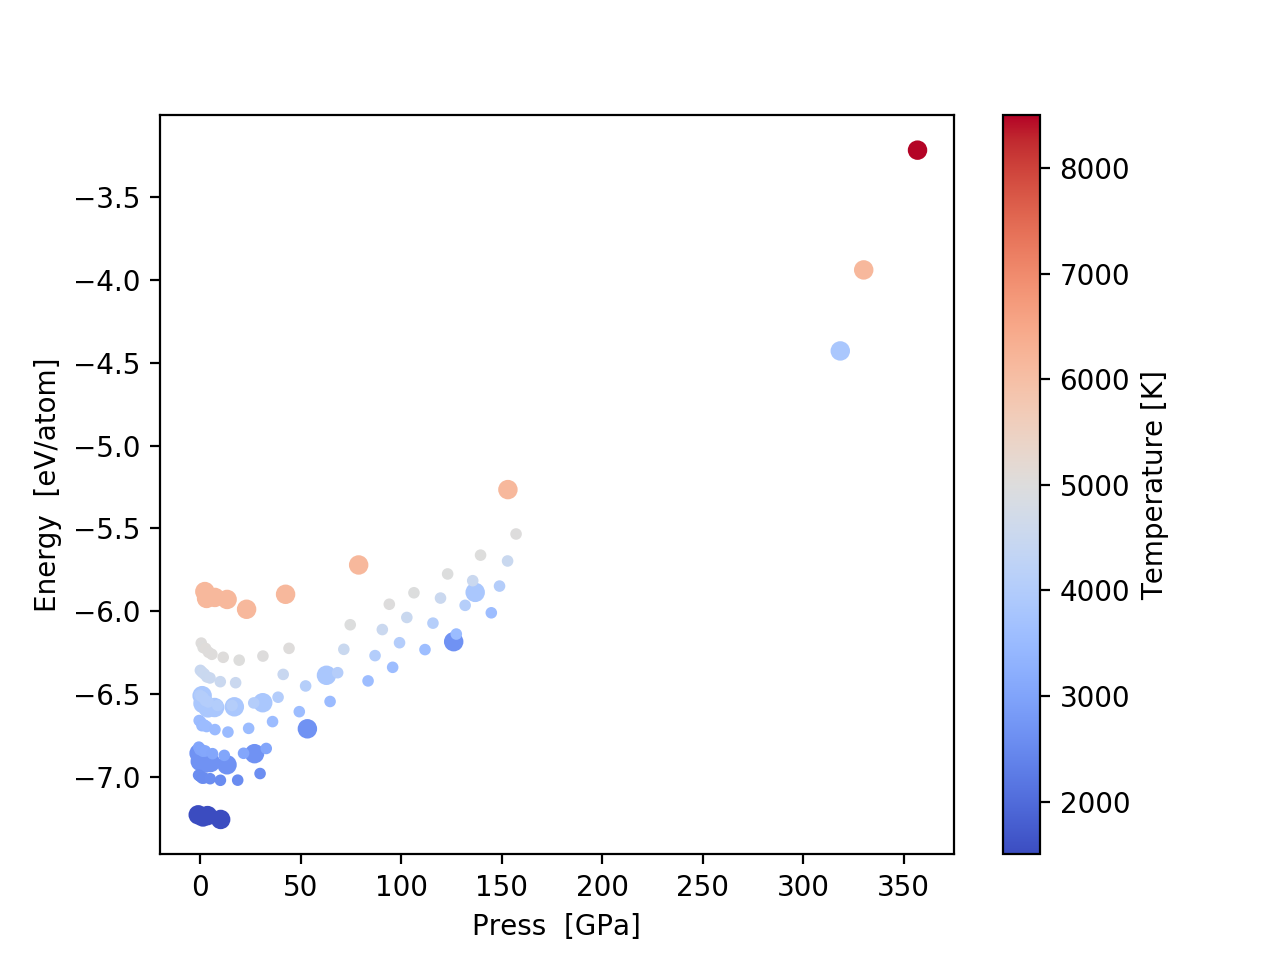

In [10]:
Tplt = [2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000]
cmap = plt.get_cmap('coolwarm',1000)
plt.figure()
plt.scatter(tbl['P'],tbl['E'],c=tbl['T'], cmap=cmap)
plt.scatter(tbl_S11['P'],tbl_S11['E']+dE0,c=tbl_S11['T'], s=10, cmap=cmap)

# for iT in Tplt:
#    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
#    plt.plot(eos_mod.press(Vmod,iT),eos_mod.internal_energy(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Press  [GPa]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

In [11]:
fit_calcs = ['compress','refstate','gamma']
fix_params = ['S0','Cvlimfac','mexp']
# fix_params = ['S0','Cvlimfac']
datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])

datamod.select_fit_params(datamodel, fit_calcs, fix_params=fix_params)
datamodel['fit_params']

['V0', 'K0', 'KP0', 'E0', 'gamma0', 'gammap0']

In [12]:
datamod.fit(datamodel)
datamod.fit(datamodel, apply_bulk_mod_wt=True)

In [13]:
display('R2fit = ', datamodel['posterior']['R2fit'])
display('Model Residual Error = ', datamodel['posterior']['fit_err'])
display(datamodel['posterior']['param_tbl'])

'R2fit = '

{'E': 0.9979879515723253, 'P': 0.9994264748400137, 'V': 0.982792238503249}

'Model Residual Error = '

{'E': 0.04510549024295923, 'P': 2.7579259833857144, 'V': 0.4461360705879314}

,name,value,error
0,V0,14.297396,0.102976
1,K0,12.120495,0.849072
2,KP0,7.200108,0.159828
3,E0,-6.878762,0.016397
4,gamma0,0.260749,0.020977
5,gammap0,-1.629780,0.181188


In [14]:
datamodel.keys()

dict_keys(['data', 'eos_mod', 'isthermal', 'err_scale', 'param_names', 'param_isfree', 'fit_params', 'bulk_mod_wt', 'posterior'])

In [15]:
prior = datamodel['posterior']
prior

OrderedDict([('param_names', ['V0', 'K0', 'KP0', 'E0', 'gamma0', 'gammap0']),
             ('param_val',
              array([14.2973962 , 12.12049517,  7.20010815, -6.87876223,  0.26074865,
                     -1.62977983])),
             ('param_err',
              array([0.10297625, 0.84907166, 0.15982831, 0.01639699, 0.02097693,
                     0.18118803])),
             ('param_tbl',       name      value     error
              0       V0  14.297396  0.102976
              1       K0  12.120495  0.849072
              2      KP0   7.200108  0.159828
              3       E0  -6.878762  0.016397
              4   gamma0   0.260749  0.020977
              5  gammap0  -1.629780  0.181188),
             ('corr',
              array([[ 1.        , -0.53267858,  0.14846845,  0.17049184, -0.26612073,
                      -0.17141422],
                     [-0.53267858,  1.        , -0.89768709, -0.22291484,  0.30469499,
                      -0.20126284],
                     [ 

* prior is used by least squares approach by transforming to eigenbasis and applying normal constraints in that context
* This prior approach is only valid if the posterior and prior estimates are nearly unchanged
* Otherwise, mabye need to adopt monte carlo approach (fixing values to those drawn from prior  and then fitting compress model with uncertainties, and repeating)
* Final assesment made based on Lange or Ghiorso properties at 1bar and 1673 K

In [16]:
corr = prior['corr']
param_err = prior['param_err']
cov = np.dot(param_err[:,np.newaxis],param_err[np.newaxis,:])*corr
cov

array([[ 1.06041071e-02, -4.65743319e-02,  2.44357091e-03,
         2.87875520e-04, -5.74854253e-04, -3.19825743e-03],
       [-4.65743319e-02,  7.20922692e-01, -1.21821248e-01,
        -3.10346899e-03,  5.42689786e-03, -3.09626015e-02],
       [ 2.44357091e-03, -1.21821248e-01,  2.55450899e-02,
         4.37885122e-04, -7.30637447e-04,  6.89884778e-03],
       [ 2.87875520e-04, -3.10346899e-03,  4.37885122e-04,
         2.68861219e-04,  2.42902426e-05, -1.27826631e-03],
       [-5.74854253e-04,  5.42689786e-03, -7.30637447e-04,
         2.42902426e-05,  4.40031707e-04,  2.73302074e-04],
       [-3.19825743e-03, -3.09626015e-02,  6.89884778e-03,
        -1.27826631e-03,  2.73302074e-04,  3.28291026e-02]])

In [17]:
np.linalg.inv(cov)

array([[  877.86487388,   225.87392294,   937.13913079,   799.52837378,
         -210.49010176,   134.50381259],
       [  225.87392294,    66.21899728,   276.93747257,   256.72391446,
          -98.96739134,    37.08220248],
       [  937.13913079,   276.93747257,  1208.86704444,   900.58622679,
         -318.24993278,   136.16864608],
       [  799.52837378,   256.72391446,   900.58622679,  6306.99235374,
        -1214.49576697,   386.45194537],
       [ -210.49010176,   -98.96739133,  -318.24993278, -1214.49576697,
         2829.93092831,  -117.81639733],
       [  134.50381259,    37.08220248,   136.16864608,   386.45194537,
         -117.81639733,    65.95125384]])

In [18]:
np.linalg.inv(corr)

array([[ 9.30897318, 19.74910851, 15.42392283,  1.35000388, -0.45468509,
         2.50958063],
       [19.74910851, 47.73877776, 37.58199148,  3.5741663 , -1.76270021,
         5.70478622],
       [15.42392283, 37.58199148, 30.88061731,  2.36016899, -1.06699903,
         3.94330476],
       [ 1.35000388,  3.5741663 ,  2.36016899,  1.69570565, -0.41773616,
         1.14812477],
       [-0.45468509, -1.76270021, -1.06699903, -0.41773616,  1.24525934,
        -0.44779293],
       [ 2.50958063,  5.70478622,  3.94330476,  1.14812477, -0.44779293,
         2.16512048]])

In [19]:
hess = np.dot(1/param_err[:,np.newaxis],1/param_err[np.newaxis,:])*np.linalg.inv(corr)
hess

array([[  877.86487388,   225.87392294,   937.13913079,   799.52837378,
         -210.49010176,   134.50381259],
       [  225.87392294,    66.21899728,   276.93747257,   256.72391446,
          -98.96739134,    37.08220248],
       [  937.13913079,   276.93747257,  1208.86704444,   900.58622679,
         -318.24993278,   136.16864608],
       [  799.52837378,   256.72391446,   900.58622679,  6306.99235374,
        -1214.49576697,   386.45194537],
       [ -210.49010176,   -98.96739134,  -318.24993278, -1214.49576697,
         2829.93092831,  -117.81639733],
       [  134.50381259,    37.08220248,   136.16864608,   386.45194537,
         -117.81639733,    65.95125384]])

In [20]:
U,S,V = np.linalg.svd(cov)
eigvecs = U
eigval = S
eigerr = np.sqrt(eigval)

In [21]:

np.dot(cov,U[:,3])/S[3]

array([ 0.60936148,  0.16353386,  0.73087735, -0.24221454,  0.08065117,
        0.05080431])

In [22]:
U[:,3]

array([ 0.60936148,  0.16353386,  0.73087735, -0.24221454,  0.08065117,
        0.05080431])

In [23]:
eigvec[0]

NameError: name 'eigvec' is not defined

In [11]:
fit_calcs = ['compress','refstate','gamma','bcoef','thermal']
fix_params = ['S0','Cvlimfac','mexp']
# fix_params = ['S0','Cvlimfac']
datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])

datamod.select_fit_params(datamodel, fit_calcs, fix_params=fix_params)
datamodel['fit_params']

['V0',
 'K0',
 'KP0',
 'E0',
 'gamma0',
 'gammap0',
 '_bcoef_0',
 '_bcoef_1',
 '_bcoef_2',
 '_bcoef_3',
 '_bcoef_4']

In [12]:
datamod.fit(datamodel)
datamod.fit(datamodel, apply_bulk_mod_wt=True)

In [13]:
display('R2fit = ', datamodel['posterior']['R2fit'])
display('Model Residual Error = ', datamodel['posterior']['fit_err'])
display(datamodel['posterior']['param_tbl'])

'R2fit = '

{'E': 0.99801901319919473, 'P': 0.99901755292686145, 'V': 0.99208007183470792}

'Model Residual Error = '

{'E': 0.047992275003960555, 'P': 3.8126232338749753, 'V': 0.31785366084848182}

,name,value,error
0,V0,14.782908,0.114450
1,K0,9.772876,0.719727
2,KP0,7.371328,0.144447
3,E0,-6.853637,0.013969
4,gamma0,0.286668,0.023258
5,gammap0,-1.275540,0.133974
6,_bcoef_0,1.133468,0.053193
7,_bcoef_1,-0.137766,0.106423
8,_bcoef_2,2.173013,1.267198
9,_bcoef_3,17.181851,5.432938


<IPython.core.display.Javascript object>


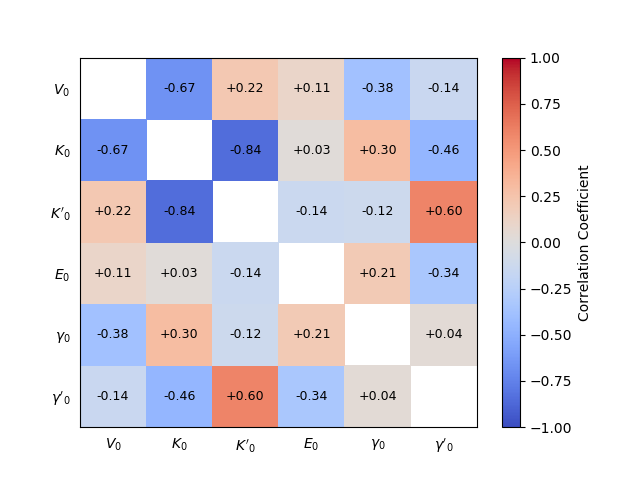

In [14]:
plt.figure()

posterior = datamodel['posterior']
corr = posterior['corr']

param_labels = [param_tex_str[name] for name in posterior['param_names']]


cmap = plt.get_cmap('coolwarm')
Nparam = len(param_labels)

corr_plt = np.flipud(np.ma.masked_where(np.eye(Nparam),corr))
plt.pcolormesh(corr_plt,cmap=cmap)


# plt.imshow(corr, cmap=cmap)
plt.clim(-1,1)
plt.colorbar(label=r'Correlation Coefficient')

plt.xticks(.5+np.arange(len(param_labels)),param_labels)
plt.yticks(np.flipud(.5+np.arange(len(param_labels))),param_labels)

for (index,val) in np.ndenumerate(np.flipud(corr)):
    if index[1]!=Nparam-1-index[0]:
        plt.text(index[1]+.5,index[0]+.5,'%+.2f'%(val),fontsize=9,
                 horizontalalignment='center', verticalalignment='center')

plt.setp(plt.gca().get_xticklines(),visible=False);
plt.setp(plt.gca().get_yticklines(),visible=False);

#plt.plot((0,11),(5,5),'k-',linewidth=2)
#plt.plot((0,11),(7,7),'k-',linewidth=2)
#plt.plot((4,4),(0,11),'k-',linewidth=2)
#plt.plot((6,6),(0,11),'k-',linewidth=2)
#plt.show()

In [15]:
from collections import OrderedDict
eos_mod = datamodel['eos_mod']
Tref = 1673
Vref = eos_mod.volume(0,Tref)
refvals = OrderedDict()
refvals['Vref'] = Vref
refvals['Kref'] = eos_mod.bulk_mod(Vref,Tref)
refvals['Cvref'] = eos_mod.heat_capacity(Vref,Tref)/models.CONSTS['kboltz']
display(refvals)

OrderedDict([('Vref', array([ 13.01903699])),
             ('Kref', array([ 15.03748061])),
             ('Cvref', array([ 4.24954775]))])

In [16]:
# datamod.fit(datamodel, apply_bulk_mod_wt=True)

<IPython.core.display.Javascript object>


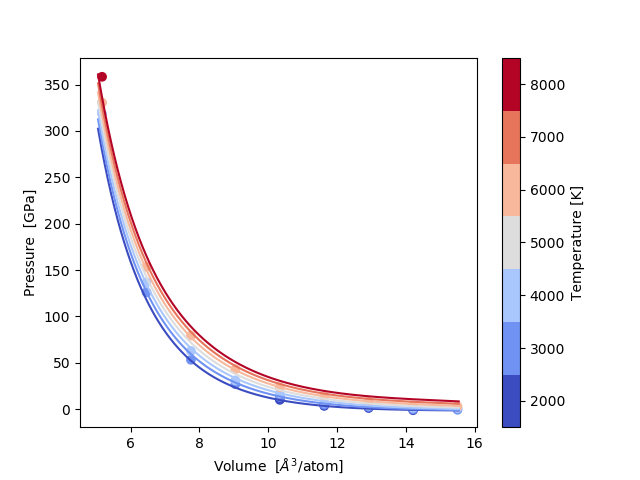

In [17]:
# Set colorbar temperature properties
cmap = plt.get_cmap('coolwarm',len(data['T_labels']))
delT = np.diff(data['T_labels'])[0]
Vmod = V0*np.linspace(.39,1.2,1001)


plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)


<IPython.core.display.Javascript object>


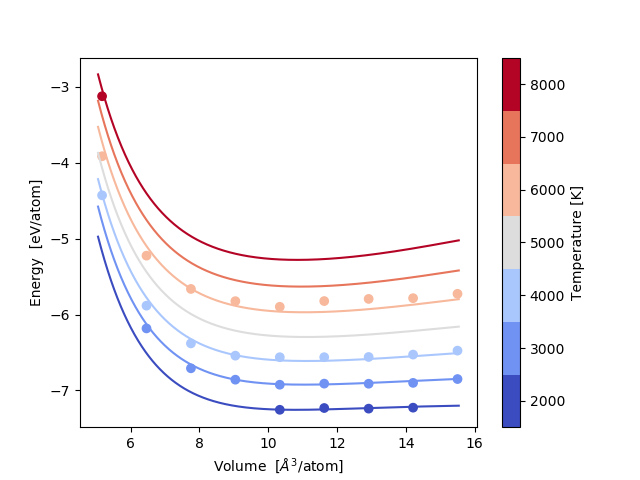

In [18]:
plt.figure()
plt.scatter(tbl['V'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.internal_energy(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

In [19]:
def material_properties(Pref, Tref, eos_mod, Vref=None):
    if Vref is None:
        Vref = eos_mod.volume(Pref, Tref, Vinit=12.8)[0]
        
    KT = eos_mod.bulk_mod(Vref,Tref)[0]
    CV = eos_mod.heat_capacity(Vref,Tref)
    alpha =  eos_mod.thermal_exp(Vref,Tref)[0]
    gamma =  eos_mod.gamma(Vref,Tref)[0]
    KS = KT*(1+alpha*gamma*Tref)
    props = OrderedDict()
    props['P'] = Pref
    props['T'] = Tref
    props['V'] = Vref
    props['KT'] = KT
    props['KS'] =  KS
    props['Cv'] = CV/CONSTS['kboltz']
    props['therm_exp'] = alpha
    props['gamma'] = gamma
    return props

model_props = material_properties(0,1673, eos_mod)
display(model_props)

OrderedDict([('P', 0),
             ('T', 1673),
             ('V', 13.019037909597685),
             ('KT', 15.037471603260855),
             ('KS', 15.636784467065795),
             ('Cv', array([ 4.24954781])),
             ('therm_exp', 8.4494319541361518e-05),
             ('gamma', 0.28193911074588729)])

In [20]:
display(analysis['props_Lange'])
display(analysis['props_Ghiorso'])

{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

{'KS': 20.850204971850488,
 'P': 0,
 'T': 1673,
 'V': 12.860873922038328,
 'alpha': 0.0001005551969012266,
 'betaS': 0.047961159199637761,
 'c': 2835.855,
 'rho': 2592.6404131697873}

In [21]:
# Save fitted model
analysis['datamodel_dK09'] = datamodel
with open(analysis_file, 'wb') as f:
    pickle.dump(analysis, f)